In [12]:
pip install --upgrade tensorflow

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
#use RobustScaler for normalization
from sklearn.preprocessing import RobustScaler
# use for learning rate schedular
from tensorflow.keras.callbacks import ReduceLROnPlateau
#for early stopping
from tensorflow.keras.callbacks import EarlyStopping
#for l2 regularization
from tensorflow.keras.regularizers import l2
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import time
import os

In [14]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv('/content/drive/MyDrive/kidney_cleaned_dadaset.csv')

In [16]:
x = df.drop("classification", axis=1).values
y = df["classification"].values


In [17]:
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [20]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.020,1,0,1,1,0,0,121,...,44,7800,5.2,1,1,0,0,0,0,0
1,7,50,1.020,4,0,1,1,0,0,121,...,38,6000,4.8,0,0,0,0,0,0,0
2,62,80,1.010,2,3,1,1,0,0,423,...,31,7500,4.8,0,1,0,1,0,1,0
3,48,70,1.005,4,0,1,0,1,0,117,...,32,6700,3.9,1,0,0,1,1,1,0
4,51,80,1.010,2,0,1,1,0,0,106,...,35,7300,4.6,0,0,0,0,0,0,0


In [21]:
model = Sequential([
    Dense(256, kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1],)),  # Increased neurons
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),


    Dense(32, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [22]:

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [23]:

history = model.fit(x_train, y_train, epochs=75, batch_size=50, validation_data=(x_test, y_test),callbacks=[early_stopping], verbose=1)


Epoch 1/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5932 - loss: 1.1033 - val_accuracy: 0.8625 - val_loss: 0.9350
Epoch 2/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6661 - loss: 0.9973 - val_accuracy: 0.9000 - val_loss: 0.9376
Epoch 3/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6786 - loss: 0.9473 - val_accuracy: 0.8375 - val_loss: 0.9415
Epoch 4/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7667 - loss: 0.8353 - val_accuracy: 0.7750 - val_loss: 0.9436
Epoch 5/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7193 - loss: 0.8570 - val_accuracy: 0.7125 - val_loss: 0.9417
Epoch 6/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7772 - loss: 0.7765 - val_accuracy: 0.7125 - val_loss: 0.9341
Epoch 7/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8239 - loss: 0.7332 - val_accuracy: 0.7250 - val_loss: 0.9248
Epoch 8/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8015 - loss: 0.7270 - val_accuracy: 0.7250 - val_loss: 0.9147


In [24]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9820 - loss: 0.3968
Test Accuracy: 98.75%


In [25]:
x_train_pca = np.array(x_train)
y_train = np.array(y_train)
train_loss, train_accuracy = model.evaluate(x_train_pca, y_train)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3785 
Train Accuracy: 100.00%


In [26]:
 #train 83.93% test 86.97%
# increases train 84.14% test 85.71% after RobustScaler normalization of data
# after making dropot 0.2 the accuracy train 86.24% test 84.45%
# after making epoch 100 train 83.51% test 84.87%
# after making learning 0.001 train 84.66% test 85.29%
# after making dropout 0.001 and epoch 75 and batch size 16 train 87.50%  test 86.13%
# after making epoch 100 and batch size 32 train 88.45% test 87.82%
# after making epoch 75 and learning rate 0.001 train 89.60% test 88.66%
# after using leakyrelu and making epoch 75 and batch size 16 train  87.18% test 87.82%

In [27]:
y_pred = model.predict(x_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Accuracy: 0.9875
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.97      1.00      0.98        30

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [28]:

# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


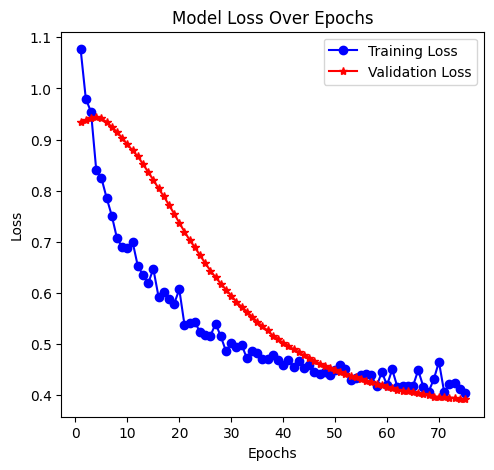

In [29]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()


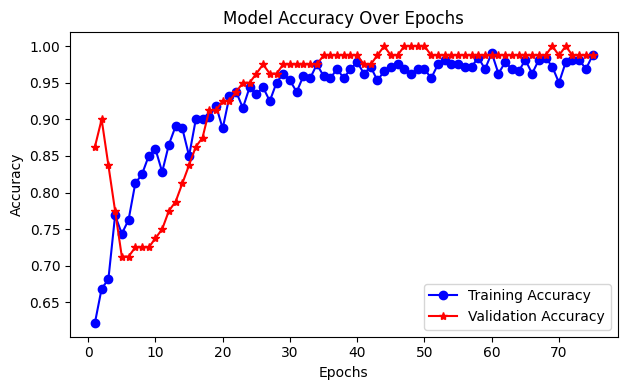

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


{'total_parameters': 51585,
 'FLOPs': 102689,
 'GFLOPs': 0.000102689,
 'model_size_bytes': 698104,
 'model_size_MB': 0.6657638549804688,
 'inference_time_seconds': 0.09091544151306152,
 'accuracy': 0.987500011920929}